In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Image
import scipy
import time
from scipy import interpolate
from scipy.interpolate import griddata
    
# Make sure that caffe is on the python path:
caffe_root = '/home/axj232/caffe/'  
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
#load our fully convolutional network 
net_full_conv = caffe.Net('deploy_full.prototxt', 
                          'full_convolutional_net.caffemodel', caffe.TEST)

In [3]:
#load our mean file and get it into the right shape
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})

a = caffe.io.caffe_pb2.BlobProto()
file = open('DB_train_w32_1.binaryproto','rb')
data = file.read()
a.ParseFromString(data)
means = a.data
means = np.asarray(means)
means = means.reshape(3, 32, 32)


transformer.set_mean('data',means.mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [4]:
#set the mode to use the GPU
caffe.set_device(0)
caffe.set_mode_gpu()

In [5]:
im_orig = caffe.io.load_image('8914_500_f00021_original.tif')

nrow_in=im_orig.shape[0] #we'll be doing padding later, 
ncol_in=im_orig.shape[1] #so lets make sure we know the original size


In [6]:
patch_size = 32 #the patch size that trained the network
hpatch_size = patch_size / 2 #half patch size...this is how much we need to mirror 
                            #the edges by to produce the same size outptu

im_orig = np.lib.pad(im_orig, ((hpatch_size, hpatch_size), \
                               (hpatch_size, hpatch_size), (0, 0)),  'symmetric')
print im_orig.shape 
#IMPORTANT: note here that the shape is 2032 x 2032, which is the same size 
#as we specified in our deploy_full text!

(2032, 2032, 3)


In [7]:
start=time.time()

#get the output 
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im_orig)])) 

#i'm only interested in the "positive class channel"
# the negative is simply 1- this channel
im_out=out['prob'][0][1,:,:] 
print "Time since beginning (after DL):\t %f"% (time.time()-start)

Time since beginning (after DL):	 1.530253


In [8]:
#what size image did our DL produce after the pooling  / convolution reductions
nrow_out=im_out.shape[0] 
ncol_out=im_out.shape[1]

#we know that the first pixel in the DL image coincides with the disired 
#first pixel in the final output image
#normally this isn't the case because we loose some of the edges, but we've
#padded it above to take this into account
start_spot_row=0 
start_spot_col=0 

#we know how bit the input image is
end_spot_row=nrow_in
end_spot_col=ncol_in

#we scale the 2 spaces appropriately
rinter=np.linspace(start_spot_row,end_spot_row,num=nrow_out) 
cinter=np.linspace(start_spot_col,end_spot_col,num=ncol_out)

In [9]:
#now we can make an interpolation function on the rigid 
#grid of this space using the output image
f = interpolate.interp2d(rinter, cinter, im_out, kind='cubic')

In [10]:
# we want to interpolate it on all integers in the final rigid 
#grid the size of the image
rnew = np.arange(start_spot_row, end_spot_row, 1)
cnew = np.arange(start_spot_col, end_spot_col, 1)

#run the interpolation to create the final output image
im_out_final = f(rnew, cnew)
print "Time since beginning (after interpolation):\t %f"% (time.time()-start)

Time since beginning (after interpolation):	 2.102489


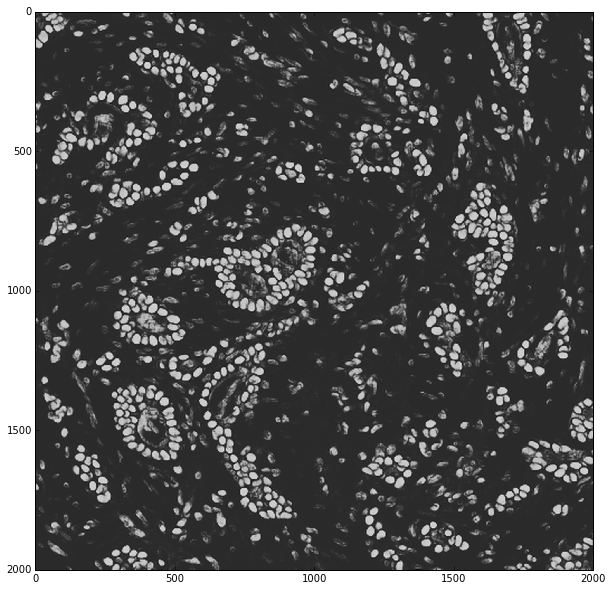

In [11]:
#check it out to see if its sane
plt.imshow(im_out_final)

In [12]:
# if we want, we can save it
scipy.misc.toimage(im_out_final, cmin=0.0, cmax=1.0).save('output.tif')